# DAT340 / DIT867 Applied Machine Learning
## Programming assignment 3c: Text classification (Part 3)


### Amr Mohamed
#### Exchange student from CY Tech - France to GU CSE Department

### Anh Thu DOAN
#### Exchange student from CY Tech - France to GU CSE Department

### Group PA3c 10

In [1]:
import pandas as pd
import numpy as np

import stanza
from scipy.stats import expon


# the actual classification algorithm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# for splitting the dataset into training and test sets 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# for evaluating the quality of the classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg' 
plt.style.use('bmh')
plt.rcParams['image.cmap'] = 'Paired_r'

In [2]:
train = pd.read_csv('PA3_train.tsv', sep='\t', names = ['annotation','review'], header=None) 
test = pd.read_csv('PA3_test_clean.tsv', sep='\t', names = ['annotation','review'], header=None) 

# Training Data Cleaning

In [3]:
train.head()

,annotation,review
0,0/0,Ordered my food the hole meal looked dead. pla...
1,1/1,We stopped her whilst walking in the Haga area...
2,0/0,"Bad experience, On 23/03/19 Myself and my part..."
3,0/0,Extremely underwhelming experience here last n...
4,0/0,Waited 30 minutes to get a table…that was ok. ...


In [4]:
train.shape

(7018, 2)

In [5]:
train.review[1]

'We stopped her whilst walking in the Haga area. The Cafe is well recommended. Good service and we enjoyed our teas and a Cinamon Roll. The latter was large but so good that between us we finished it! Recommended stop off.'

In [6]:
train[['annotation1','annotation2']]=train.annotation.str.split('/', expand=True)

In [7]:
train.head()

,annotation,review,annotation1,annotation2
0,0/0,Ordered my food the hole meal looked dead. pla...,0,0
1,1/1,We stopped her whilst walking in the Haga area...,1,1
2,0/0,"Bad experience, On 23/03/19 Myself and my part...",0,0
3,0/0,Extremely underwhelming experience here last n...,0,0
4,0/0,Waited 30 minutes to get a table…that was ok. ...,0,0


In [8]:
train.annotation.unique()

array(['0/0', '1/1', '1/0', '-1/0', '-1/1', '0/1', '2/1', '2/0', '1/',
       '9/1'], dtype=object)

In [9]:
train.annotation1.unique()

array(['0', '1', '-1', '2', '9'], dtype=object)

In [10]:
train.annotation2.unique()

array(['0', '1', ''], dtype=object)

In [11]:
total_disagreement = round(len(train[~train.annotation.isin(['1/1', '0/0'])].annotation)/len(train.annotation),3)
print("The percentage of disagreement between the annotators is: "+ str(total_disagreement))

The percentage of disagreement between the annotators is: 0.056


In [12]:
true_disagreement = round(len(train[train.annotation.isin(['1/0', '0/1'])].annotation)/len(train.annotation),3)
print("The percentage of real disagreement between the annotators is (0/1 or 1/0): "+ str(true_disagreement))

The percentage of real disagreement between the annotators is (0/1 or 1/0): 0.038


In [13]:
false_disagreement = round(len(train[~train.annotation.isin(['0/0', '1/1', '1/0', '0/1'])].annotation)/len(train.annotation),3)
print("The percentage of misannotated reviews led to\na difference in the annotations between the annotators is: "+ str(false_disagreement))

The percentage of misannotated reviews led to
a difference in the annotations between the annotators is: 0.019


## Sentiment analysis on rows with an annotation disagreement

In [14]:
# Stanza library for sentiment analysis
nlp = stanza.Pipeline(lang='en', processors='tokenize, sentiment')

2022-04-28 22:11:56 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-04-28 22:11:56 INFO: Use device: cpu
2022-04-28 22:11:56 INFO: Loading: tokenize
2022-04-28 22:11:56 INFO: Loading: sentiment
2022-04-28 22:11:57 INFO: Done loading processors!


In [15]:
# collecting the sentiment scores for instances with disagreement
sent_scores = []
cpt=0
for index, row in train.iterrows():
    if row.annotation in ['1/0', '-1/0', '-1/1', '0/1', '2/1', '2/0', '1/','9/1']:
        doc = nlp(row.review)
        for sentence in doc.sentences:
            temp = []
            temp.append(int(sentence.sentiment)-1)
        sent_scores.append(sum(temp)/len(temp))
        print(cpt, end='\r')
    else:
        sent_scores.append(3)
    cpt+=1

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [16]:
train['sent_ana']=sent_scores
train.head(10)

,annotation,review,annotation1,annotation2,sent_ana
0,0/0,Ordered my food the hole meal looked dead. pla...,0,0,3.0
1,1/1,We stopped her whilst walking in the Haga area...,1,1,3.0
2,0/0,"Bad experience, On 23/03/19 Myself and my part...",0,0,3.0
3,0/0,Extremely underwhelming experience here last n...,0,0,3.0
4,0/0,Waited 30 minutes to get a table…that was ok. ...,0,0,3.0
5,0/0,"A mediocre burger, not tasteful",0,0,3.0
6,1/0,As a Kiwi guy constantly on the hunt for decen...,1,0,-1.0
7,0/0,"If you go in here, don't go in before mystery ...",0,0,3.0
8,0/0,It's in a great location. That's it. Their pri...,0,0,3.0
9,1/1,About 200 people queuing in a small street at ...,1,1,3.0


In [17]:
train.shape

(7018, 5)

In [18]:
train = train[train.sent_ana!=0]

In [19]:
train.shape

(6940, 5)

In [20]:
train.sent_ana = train.sent_ana.replace(-1,0)

In [21]:
train.head(10)

,annotation,review,annotation1,annotation2,sent_ana
0,0/0,Ordered my food the hole meal looked dead. pla...,0,0,3.0
1,1/1,We stopped her whilst walking in the Haga area...,1,1,3.0
2,0/0,"Bad experience, On 23/03/19 Myself and my part...",0,0,3.0
3,0/0,Extremely underwhelming experience here last n...,0,0,3.0
4,0/0,Waited 30 minutes to get a table…that was ok. ...,0,0,3.0
5,0/0,"A mediocre burger, not tasteful",0,0,3.0
6,1/0,As a Kiwi guy constantly on the hunt for decen...,1,0,0.0
7,0/0,"If you go in here, don't go in before mystery ...",0,0,3.0
8,0/0,It's in a great location. That's it. Their pri...,0,0,3.0
9,1/1,About 200 people queuing in a small street at ...,1,1,3.0


In [22]:
# replacing the correctly annotated instances by their annotations after the sentiment analysi
train.loc[train['sent_ana'] == 3, 'sent_ana'] = train['annotation2']

In [23]:
train.sent_ana = train.sent_ana.astype(int)
train.head(10)

,annotation,review,annotation1,annotation2,sent_ana
0,0/0,Ordered my food the hole meal looked dead. pla...,0,0,0
1,1/1,We stopped her whilst walking in the Haga area...,1,1,1
2,0/0,"Bad experience, On 23/03/19 Myself and my part...",0,0,0
3,0/0,Extremely underwhelming experience here last n...,0,0,0
4,0/0,Waited 30 minutes to get a table…that was ok. ...,0,0,0
5,0/0,"A mediocre burger, not tasteful",0,0,0
6,1/0,As a Kiwi guy constantly on the hunt for decen...,1,0,0
7,0/0,"If you go in here, don't go in before mystery ...",0,0,0
8,0/0,It's in a great location. That's it. Their pri...,0,0,0
9,1/1,About 200 people queuing in a small street at ...,1,1,1


In [24]:
train_df=train[['review', 'sent_ana']]
train_df=train_df.rename(columns={"sent_ana": "annotation"})
train_df.annotation=pd.to_numeric(train_df.annotation)

In [25]:
train_df.head()

,review,annotation
0,Ordered my food the hole meal looked dead. pla...,0
1,We stopped her whilst walking in the Haga area...,1
2,"Bad experience, On 23/03/19 Myself and my part...",0
3,Extremely underwhelming experience here last n...,0
4,Waited 30 minutes to get a table…that was ok. ...,0


In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6940 entries, 0 to 7017
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      6940 non-null   object
 1   annotation  6940 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 420.7+ KB


In [27]:
print('Number of positive reviews in the training set',len(train_df[train_df.annotation == 1].annotation))

Number of positive reviews in the training set 3619


In [28]:
print('Number of negative reviews in the training set',len(train_df[train_df.annotation == 0].annotation))

Number of negative reviews in the training set 3321


# Test data cleaning

In [29]:
test.head()

,annotation,review
0,0,Over all I felt a bit disappointing with abov...
1,1,A wonderful experience!
2,1,Always very delicious dishes and attentive ser...
3,1,Amazing as always
4,1,"Amazing food, the aubergine mess and the Tunis..."


In [30]:
test.shape

(1751, 2)

In [31]:
test.annotation.unique()

array([0, 1])

In [32]:
test[test.annotation== 1 ].annotation.count()

886

In [33]:
test[test.annotation== 0 ].annotation.count()

865

In [34]:
# cleaning the text by converting all words in all the reviews to lowercase letters
def clean_text(text):
    # filter to allow only alphabets
#     text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    # remove Unicode characters
#     text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # convert to lowercase to maintain consistency
    text = text.lower()
       
    return text

train_df['review'] = train_df.review.apply(clean_text)
test['review'] = test.review.apply(clean_text)

In [35]:
# defining the training and testing sets
X_train = (train_df.review)
Y_train=train_df.annotation
X_test = (test.review)
Y_test=test.annotation

# ML models

## Dummy Classifier

In [36]:
#Baseline classifier with most-frequent strategy
dummy = DummyClassifier(strategy='most_frequent',random_state=0)
pipeline = make_pipeline( TfidfVectorizer(), dummy)
pipeline.fit(X_train, Y_train)
print('The accuracy of Dummy Classifier:',accuracy_score(Y_test, pipeline.predict(X_test)))

The accuracy of Dummy Classifier: 0.5059965733866362


## Linear SVC

In [37]:
LSVCpipeline = Pipeline( [(
    'tfidf',TfidfVectorizer()), 
    ('linearsvc',LinearSVC(random_state=0))])
LSVCpipeline.fit(X_train, Y_train)
Yguess = LSVCpipeline.predict(X_test)
print('The accuracy of Linear SVC with default parameters and random state equal to zero:',accuracy_score(Y_test, Yguess))

The accuracy of Linear SVC with default parameters and random state equal to zero: 0.9674471730439749


## Support Vector Classification (SVC)

In [38]:
SVCpipeline = Pipeline( [(
    'tfidf',TfidfVectorizer()), 
    ('svc',SVC(random_state=0))])
SVCpipeline.fit(X_train, Y_train)
print('The accuracy of SVC with default parameters and random state equal to zero:',accuracy_score(Y_test, SVCpipeline.predict(X_test)))

The accuracy of SVC with default parameters and random state equal to zero: 0.9674471730439749


## Logistic Regression

In [39]:
logRpipeline = Pipeline( [(
    'tfidf',TfidfVectorizer()), 
    ('logr',LogisticRegression(random_state=0))])
logRpipeline.fit(X_train, Y_train)
print('The accuracy of Logistic regession with default parameters and random state equal to zero:',accuracy_score(Y_test, logRpipeline.predict(X_test)))

The accuracy of Logistic regession with default parameters and random state equal to zero: 0.9611650485436893


## Gradient Boosting Classifier

In [40]:
pipeline = make_pipeline( TfidfVectorizer(), GradientBoostingClassifier(random_state=0))
pipeline.fit(X_train, Y_train)
print('The accuracy of Gradient Boosting Classifier with default parameters and random state equal to zero:',accuracy_score(Y_test, pipeline.predict(X_test)))

The accuracy of Gradient Boosting Classifier with default parameters and random state equal to zero: 0.9166190748143918


## Random Forest Classifier

In [41]:
pipeline = make_pipeline( TfidfVectorizer(), RandomForestClassifier(random_state=0))
pipeline.fit(X_train, Y_train)
print('The accuracy of Random Forest Classifier with default parametersand random state equal to zero:',accuracy_score(Y_test, pipeline.predict(X_test)))

The accuracy of Random Forest Classifier with default parametersand random state equal to zero: 0.9354654483152485


## Multinomial Naive Baye

In [42]:
pipeline = make_pipeline( TfidfVectorizer(), MultinomialNB())
pipeline.fit(X_train, Y_train)
print('The accuracy of Multinomial Naive Baye with default parameters:',accuracy_score(Y_test, pipeline.predict(X_test)))

The accuracy of Multinomial Naive Baye with default parameters: 0.9480296973158195


## Multi-layer Perceptron classifier

In [43]:
NN = MLPClassifier(early_stopping=True,n_iter_no_change=10)
pipeline = make_pipeline( TfidfVectorizer(),NN)
pipeline.fit(X_train, Y_train)
print('The accuracy of Multi-layer Perceptron classifier:',accuracy_score(Y_test, pipeline.predict(X_test)))

The accuracy of Multi-layer Perceptron classifier: 0.960022844089092


In [44]:
NN = MLPClassifier(alpha = 0.1, max_iter=400,early_stopping=True,n_iter_no_change=3)
pipeline = make_pipeline( TfidfVectorizer(),NN)
pipeline.fit(X_train, Y_train)
print('The accuracy of Multi-layer Perceptron classifier:',accuracy_score(Y_test, pipeline.predict(X_test)))

The accuracy of Multi-layer Perceptron classifier: 0.9680182752712736


# Highest scoring models Tuning and evaluation (SVC and Linear SVC)

## Hyperparameter Tuning Linear SVC

In [45]:
#hyperparamaeter tuning
LSVCpipeline = Pipeline( [(
    'tfidf',TfidfVectorizer()), 
    ('linearsvc',LinearSVC(random_state=0))])

#construct the paramter grid
param_grid = {'tfidf__max_df': [0.1,0.275,0.3545454545454545,0.3,0.5,0.75,1],
            'linearsvc__loss': ['hinge','squared_hinge'],
              'linearsvc__C': [0.01,0.1,1.0],
             'linearsvc__penalty': ['l1','l2'],
             'linearsvc__random_state': [0]}
 
LSVCgrid = GridSearchCV(LSVCpipeline, param_grid,n_jobs=-1)
 
# fitting the model for grid search
LSVCgrid.fit(X_train, Y_train)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_est

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Applications/anaconda3/lib/python3

  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_est

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('linearsvc',
                                        LinearSVC(random_state=0))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [0.01, 0.1, 1.0],
                         'linearsvc__loss': ['hinge', 'squared_hinge'],
                         'linearsvc__penalty': ['l1', 'l2'],
                         'linearsvc__random_state': [0],
                         'tfidf__max_df': [0.1, 0.275, 0.3545454545454545, 0.3,
                                           0.5, 0.75, 1]})

In [46]:
LSVCgrid.best_params_

{'linearsvc__C': 1.0,
 'linearsvc__loss': 'squared_hinge',
 'linearsvc__penalty': 'l2',
 'linearsvc__random_state': 0,
 'tfidf__max_df': 0.275}

In [47]:
LSVCgrid.best_score_

0.9580691642651299

In [48]:
print('The accuracy score of LSVC after tuning by grid search:',accuracy_score(Y_test, LSVCgrid.predict(X_test)))

The accuracy score of LSVC after tuning by grid search: 0.9668760708166761


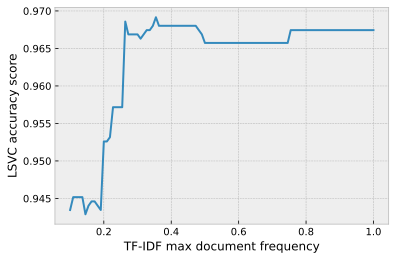

In [49]:
#plotting the max_df tfidf parameter values over the accuracies of the linearsvc model

max_dfList=[]
for i in list(np.linspace(0.1,1,100)): 
    LSVCpipeline = Pipeline( [(
    'tfidf',TfidfVectorizer(max_df=i)), 
    ('svc',LinearSVC(random_state=0))])
    LSVCpipeline.fit(X_train, Y_train)
    max_dfList.append(accuracy_score(Y_test, LSVCpipeline.predict(X_test)))

plt.plot(list(np.linspace(0.1,1,100)),max_dfList)
plt.xlabel('TF-IDF max document frequency')
plt.ylabel('LSVC accuracy score');

In [50]:
LSVCpipeline = Pipeline( [(
    'tfidf',TfidfVectorizer(max_df=0.3545454545454545)), 
    ('linearsvc',LinearSVC(random_state=0))])
LSVCpipeline.fit(X_train, Y_train)
LSVC_Yguess = LSVCpipeline.predict(X_test)
print('The accuracy of LSVC with the best value for max_df:',accuracy_score(Y_test, LSVC_Yguess))

The accuracy of LSVC with the best value for max_df: 0.9691604797258709


## Hyperparameter Tuning SVC

In [51]:
#hyperparamaeter tuning
param_grid = {'tfidf__max_df': [0.2,0.225,0.275,0.3],
              'svc__kernel': ['poly', 'rbf', 'sigmoid'],
              'svc__C': [0.3,0.5,0.7,1]}
SVCgs = GridSearchCV(SVCpipeline, param_grid, n_jobs=-1)
SVCgs.fit(X_train, Y_train);

In [52]:
SVCgs.best_params_

{'svc__C': 1, 'svc__kernel': 'rbf', 'tfidf__max_df': 0.275}

In [53]:
SVCgs.best_score_

0.9589337175792508

In [54]:
accuracy_score(Y_test, SVCgs.predict(X_test))

0.970873786407767

In [55]:
#plotting the max_df tfidf parameter values over the accuracies of the svc model
max_dfList=[]
for i in list(np.linspace(0.1,1,100)): 
    SVCpipeline = Pipeline( [(
    'tfidf',TfidfVectorizer(max_df=i)), 
    ('svc',SVC(random_state=0))])
    SVCpipeline.fit(X_train, Y_train)
    max_dfList.append(accuracy_score(Y_test, SVCpipeline.predict(X_test)))

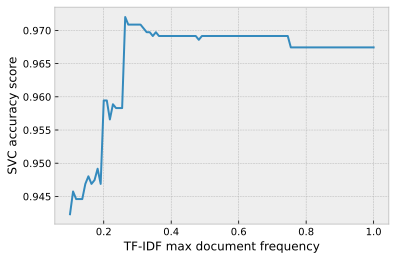

In [56]:
plt.plot(list(np.linspace(0.1,1,100)),max_dfList)
plt.xlabel('TF-IDF max document frequency')
plt.ylabel('SVC accuracy score');

In [57]:
dict(zip(max_dfList,list(np.linspace(0.1,0.5,40))))

{0.9423186750428326: 0.1,
 0.9457452884066248: 0.11025641025641027,
 0.9446030839520274: 0.14102564102564102,
 0.9468874928612222: 0.20256410256410257,
 0.9480296973158195: 0.16153846153846155,
 0.9474585950885208: 0.18205128205128207,
 0.9491719017704169: 0.19230769230769232,
 0.9594517418617933: 0.2230769230769231,
 0.9565962307252999: 0.23333333333333334,
 0.9588806396344945: 0.24358974358974358,
 0.9583095374071959: 0.2743589743589744,
 0.9720159908623643: 0.2846153846153846,
 0.970873786407767: 0.3358974358974359,
 0.9703026841804683: 0.34615384615384615,
 0.9697315819531697: 0.38717948717948714,
 0.9691604797258709: 0.5}

In [58]:
SVCpipeline = Pipeline( [(
    'tfidf',TfidfVectorizer(max_df=0.2641025641025641)), 
    ('svc',SVC())])
SVCpipeline.fit(X_train, Y_train)
accuracy_score(Y_test, SVCpipeline.predict(X_test))

0.9720159908623643

## Linear SVC evaluation

In [59]:
#getting the confusion matrix
cf_matrix =confusion_matrix(Y_test, LSVC_Yguess)

In [60]:
print(classification_report(Y_test, LSVC_Yguess))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       865
           1       0.97      0.97      0.97       886

    accuracy                           0.97      1751
   macro avg       0.97      0.97      0.97      1751
weighted avg       0.97      0.97      0.97      1751



In [61]:
cf_matrix

array([[842,  23],
       [ 31, 855]])

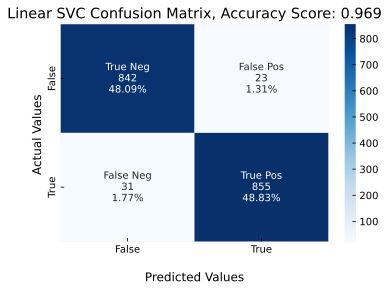

In [62]:
#Plotting confusion matrix for LSVC
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Linear SVC Confusion Matrix, Accuracy Score: %.3f' % accuracy_score(Y_test, LSVC_Yguess));
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [63]:
print("Precision score of LSVC:",precision_score(Y_test, LSVC_Yguess, pos_label=1),
      "\nRecall score of LSVC:",recall_score(Y_test, LSVC_Yguess, pos_label=1))

Precision score of LSVC: 0.9738041002277904 
Recall score of LSVC: 0.9650112866817155


##  SVC evaluation

In [64]:
cf_matrix =confusion_matrix(Y_test, SVCpipeline.predict(X_test))

In [65]:
print(classification_report(Y_test, SVCpipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       865
           1       0.98      0.96      0.97       886

    accuracy                           0.97      1751
   macro avg       0.97      0.97      0.97      1751
weighted avg       0.97      0.97      0.97      1751



In [66]:
cf_matrix

array([[848,  17],
       [ 32, 854]])

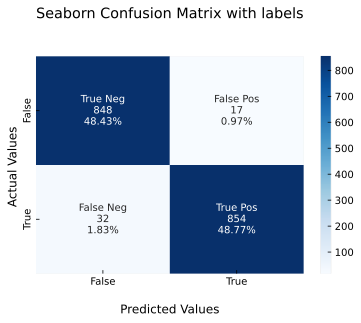

In [67]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [68]:
print("Precision score of SVC:",precision_score(Y_test, SVCpipeline.predict(X_test), pos_label=1),
      "\nRecall score of SVC:",recall_score(Y_test, SVCpipeline.predict(X_test), pos_label=1))

Precision score of SVC: 0.9804822043628014 
Recall score of SVC: 0.963882618510158


In [69]:
print(classification_report(Y_test, SVCpipeline.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       865
           1       0.98      0.96      0.97       886

    accuracy                           0.97      1751
   macro avg       0.97      0.97      0.97      1751
weighted avg       0.97      0.97      0.97      1751



# Precision/Recall curves comparison for Linear SVC and SVC

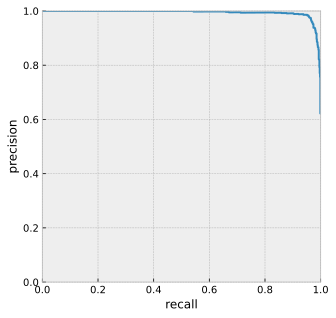

In [70]:
scores = LSVCpipeline.decision_function(X_test)

precs, recs, _ = precision_recall_curve(Y_test, scores, pos_label=1)

plt.figure(figsize=(5,5))
plt.plot(recs, precs)
plt.xlabel('recall')
plt.ylabel('precision')
plt.axis([0, 1, 0, 1]);

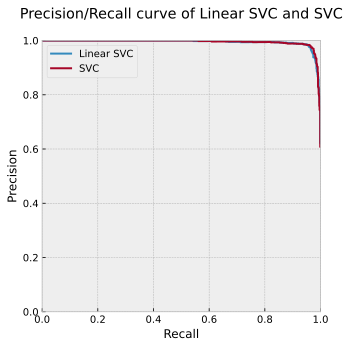

In [71]:
#Plotting the precision & recall curve for SVC & LSVC
pipelines = [LSVCpipeline,SVCpipeline]

APs = []
plt.figure(figsize=(5,5))
for pipeline in pipelines:
    scores = pipeline.decision_function(X_test)
    precisions, recalls, _ = precision_recall_curve(Y_test, scores, pos_label=1)
    
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
plt.legend(['Linear SVC','SVC']);
plt.title('Precision/Recall curve of Linear SVC and SVC\n' )
plt.axis([0, 1, 0, 1]);

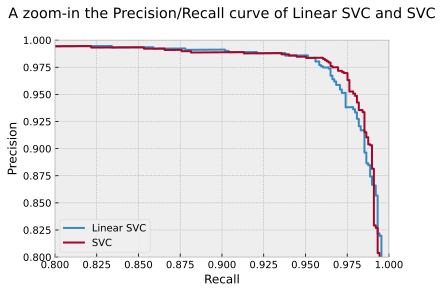

In [72]:
#Zoom-in the PR of SVC and LSVC
for pipeline in pipelines:
    scores = pipeline.decision_function(X_test)
    precisions, recalls, _ = precision_recall_curve(Y_test, scores, pos_label=1)
    
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
# leg_labels = [ '{:3}: AP = {:.3f}'.format(n, AP) for n, AP in APs ]
plt.legend(['Linear SVC','SVC']);
plt.title('A zoom-in the Precision/Recall curve of Linear SVC and SVC\n' )
plt.axis([0.8, 1, 0.8, 1]);

# LSVC Misclassified instances sample

In [73]:
tempdf= test 
tempdf['LSVC_predicted'] = LSVC_Yguess
tempdf[tempdf.LSVC_predicted != tempdf.annotation].head().review.values

array(['no reasonably priced set lunch menu.\xa0',
       'they don’t have a chef and they just warm the foods because they’re already cooked it and it comes in packaged when you order they just warm the food and topped with oil to look nice',
       "we ate here last night after a film, the food was great and prices reasonable. better still, i accidentally ordered a biryani with chicken in it (i'm a vegetarian) and they took it back and changed it for a veggie biryani without charging me for it, even though it was totally my fault. that's classy. they also wouldn't take any service charge...would definitely come again!",
       "while visiting london and staying in brick lane, we checked into our hotel in the early hours of the morning. we saw that the monsoon was open so headed in for a meal. they had closed for the evening but cooked us a meal for us to take away . while waiting, we were able to have a drink. as we were in a hotel room, we had no cutlery or bowls to use, so staff so

# SVC Misclassified instances sample

In [74]:
tempdf['SVC_predicted'] = SVCpipeline.predict(X_test)
tempdf[tempdf.SVC_predicted != tempdf.annotation].head().review.values

array(['no reasonably priced set lunch menu.\xa0',
       "we ate here last night after a film, the food was great and prices reasonable. better still, i accidentally ordered a biryani with chicken in it (i'm a vegetarian) and they took it back and changed it for a veggie biryani without charging me for it, even though it was totally my fault. that's classy. they also wouldn't take any service charge...would definitely come again!",
       "while visiting london and staying in brick lane, we checked into our hotel in the early hours of the morning. we saw that the monsoon was open so headed in for a meal. they had closed for the evening but cooked us a meal for us to take away . while waiting, we were able to have a drink. as we were in a hotel room, we had no cutlery or bowls to use, so staff sorted us some plastic cutlery and two plastic take away pots for us to use as bowls. they even threw in a bottle of cobra. they couldn't have been more helpful, in the early hours of the morning

# Features importance

# LSVC

In [75]:
feature_names = LSVCpipeline.named_steps["tfidf"].get_feature_names()

In [76]:
coefs = LSVCpipeline.named_steps["linearsvc"].coef_.flatten()

In [77]:
zipped = zip(feature_names, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

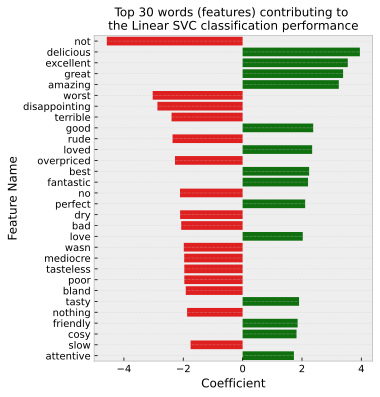

In [78]:
sns.set_style( {"grid.color": ".8", "grid.linestyle": ":"})

fig, ax = plt.subplots(1, 1, figsize=(5, 6))
sns.barplot(y="feature",
            x="value",
            data=df.head(30),
           palette=df.head(30)["colors"])
ax.set_title("Top 30 words (features) contributing to \nthe Linear SVC classification performance", fontsize=12)
ax.set_ylabel("Feature Name", fontsize=12)
ax.set_xlabel("Coefficient", fontsize=12)
plt.grid()